<a href="https://colab.research.google.com/github/Raunaq14/DLF_Assignment_3/blob/main/Assignment_3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import kagglehub
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, GRU
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import Huber

In [2]:
# Download the dataset using KaggleHub
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")
print("Path to dataset files:", path)

# Locate the folder containing the .csv files
data_dir = os.path.join(path, "stock_market_data/nasdaq/csv")  # Adjust to target a specific folder like 'nasdaq/csv'
print(f"Using data from directory: {data_dir}")

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74
Using data from directory: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74/stock_market_data/nasdaq/csv


In [3]:
# Function to load and combine multiple files
def load_and_combine_files(directory, n_files=5):
    combined_data = []
    file_count = 0
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path)
            combined_data.append(data)
            file_count += 1
            if file_count >= n_files:  # Limit to n_files for demonstration
                break
    return pd.concat(combined_data, ignore_index=True)

# Load a subset of files
data = load_and_combine_files(data_dir, n_files=5)

# Display dataset information
print("Combined Dataset Info:")
print(data.info())
print(data.head())

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25172 entries, 0 to 25171
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            25172 non-null  object 
 1   Low             25172 non-null  float64
 2   Open            25172 non-null  float64
 3   Volume          25172 non-null  int64  
 4   High            25172 non-null  float64
 5   Close           25172 non-null  float64
 6   Adjusted Close  25172 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ MB
None
         Date     Low     Open  Volume   High    Close  Adjusted Close
0  19-12-1994  2.9375  2.93750  384800  3.250  3.00000         3.00000
1  20-12-1994  2.8750  3.12500  109400  3.125  2.96875         2.96875
2  21-12-1994  2.8750  2.96875   49200  3.000  2.87500         2.87500
3  22-12-1994  2.8750  3.12500   20900  3.125  3.00000         3.00000
4  23-12-1994  3.0000  3.00000       0  3.

In [4]:
# Feature engineering
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')  # Added dayfirst=True for proper parsing
data = data.sort_values('Date')

# Feature engineering
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_14'] = data['Close'].rolling(window=14).mean()
data['Close_pct_change'] = data['Close'].pct_change()
data['Volume_pct_change'] = data['Volume'].pct_change()
data['High_Low_Spread'] = data['High'] - data['Low']

# Drop rows with NaN or infinite values
data = data.dropna()
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# Normalize features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume',
                                         'MA_7', 'MA_14', 'Close_pct_change',
                                         'Volume_pct_change', 'High_Low_Spread']])

In [5]:
# Dataset preparation
def create_dataset(dataset, look_back=30, predict_forward=1):
    X, Y = [], []
    for i in range(look_back, len(dataset) - predict_forward + 1):
        X.append(dataset[i - look_back:i])
        Y.append(dataset[i + predict_forward - 1, 3])  # Predict 'Close' price
    return np.array(X), np.array(Y)

# Splitting the data
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.2)
train_data, val_data, test_data = (
    data_scaled[:train_size],
    data_scaled[train_size:train_size + val_size],
    data_scaled[train_size + val_size:]
)

# Create datasets
look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_val, Y_val = create_dataset(val_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Model architecture
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=False)),
    Dropout(0.3),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss=Huber())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100
534/534 - 10s - 19ms/step - loss: 0.0067 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/100
534/534 - 5s - 10ms/step - loss: 0.0046 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 3/100
534/534 - 10s - 18ms/step - loss: 0.0044 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 4/100
534/534 - 5s - 9ms/step - loss: 0.0044 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 5/100
534/534 - 4s - 8ms/step - loss: 0.0043 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 6/100
534/534 - 6s - 11ms/step - loss: 0.0042 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 7/100
534/534 - 4s - 8ms/step - loss: 0.0042 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 8/100
534/534 - 4s - 8ms/step - loss: 0.0042 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 9/100
534/534 - 6s - 11ms/step - loss: 0.0042 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 10/100

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
534/534 - 11s - 20ms/step - loss: 0.0042 - val_loss: 0.0

In [7]:
# Evaluate the model
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions_full = np.zeros((predictions.shape[0], data_scaled.shape[1]))
predictions_full[:, -1] = predictions.flatten()
predictions = scaler.inverse_transform(predictions_full)[:, -1]

Y_test_full = np.zeros((Y_test.shape[0], data_scaled.shape[1]))
Y_test_full[:, -1] = Y_test.flatten()
Y_test_actual = scaler.inverse_transform(Y_test_full)[:, -1]

# Metrics
mse = mean_squared_error(Y_test_actual, predictions)
mae = mean_absolute_error(Y_test_actual, predictions)
r2 = r2_score(Y_test_actual, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error: 86.60483214176679
Mean Absolute Error: 7.934128883806783
R² Score: 0.0254221570638532


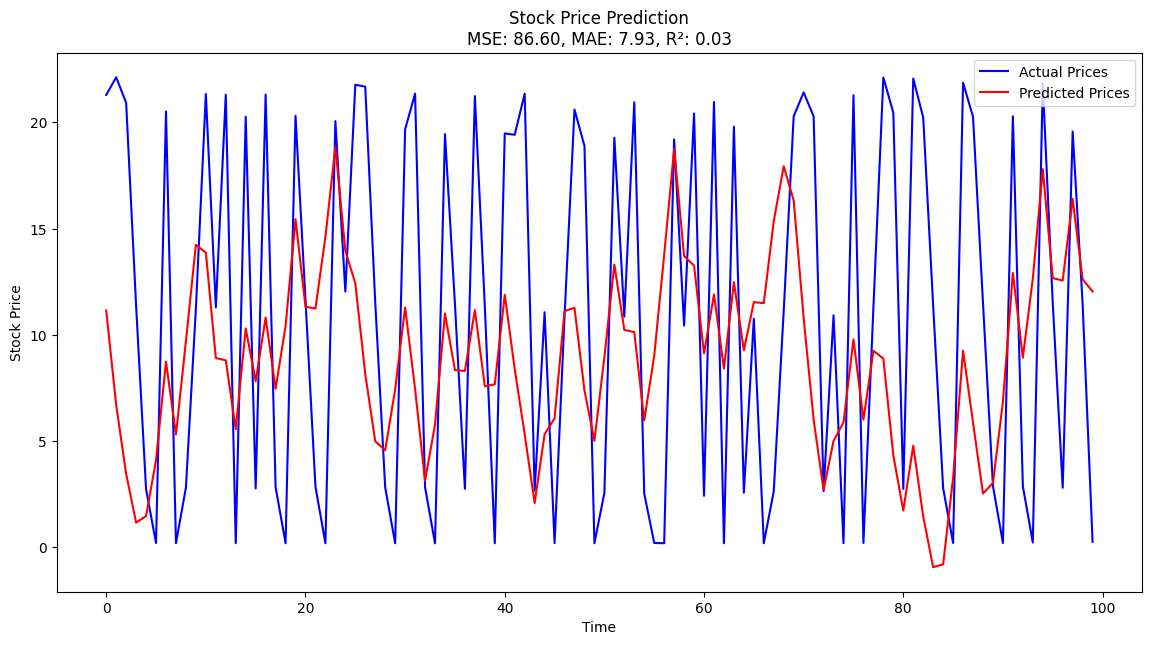

In [8]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(Y_test_actual[:100], label="Actual Prices", color="blue")
plt.plot(predictions[:100], label="Predicted Prices", color="red")
plt.title(f"Stock Price Prediction\nMSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

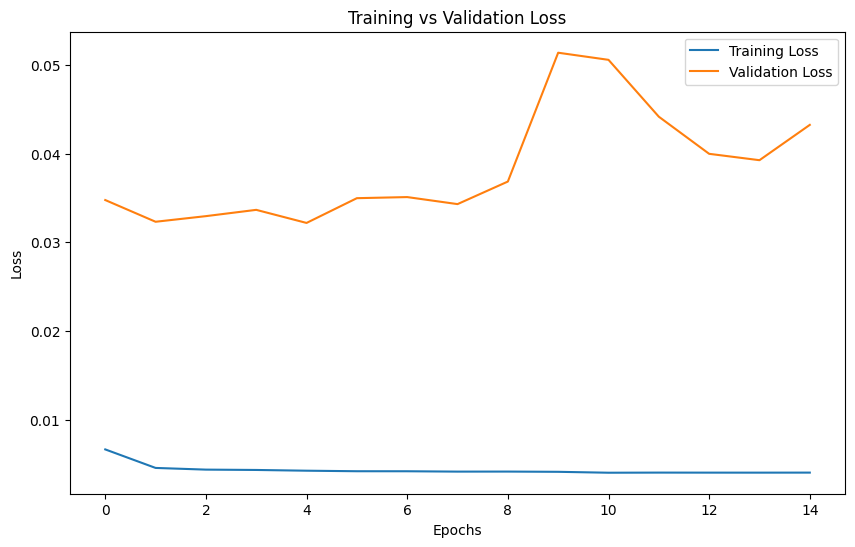

In [9]:
# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()